# Introduction
The Materials Project is one of the most influential open‑access platforms in computational materials science, designed to accelerate discovery by providing high‑quality, density‑functional‑theory (DFT)–computed properties for tens of thousands of inorganic compounds. It serves as a centralized, searchable database where researchers can explore crystal structures, thermodynamic stability, electronic properties, and more. One of its most widely used datasets is the band gap, a fundamental electronic property that determines whether a material behaves as a metal, semiconductor, or insulator. Band gap values in the Materials Project are computed using standardized DFT workflows, ensuring consistency across the entire database. These values can be accessed programmatically through the Materials Project API or downloaded through curated datasets, making it straightforward to build machine‑learning models that learn structure–property relationships.

In this project, the band gap serves as the target property we aim to predict using a Random Forest regression model trained on composition‑based descriptors. This raises a natural research question:

- How can we design a random forest model that reliably predicts the band gap of a new material using only its chemical composition?

More specifically, we can ask: What features extracted from composition best capture the underlying physics? How much training data is required to achieve stable predictive performance? And how well does the model generalize to new chemical families not represented in the training set? By addressing these questions, we move closer to the broader goal of self‑driving laboratories—systems that can intelligently prioritize which materials to compute or synthesize next.

# Analysis

## Import Data from Materials Project

**Issues arrived from multiple python versions that kept conflicting with each other  
Before beginning ensure that 3.13.9 and pymatgen 2025.10.7 are running**

In [2]:
import sys
import pkg_resources

print("Python version:", sys.version)
print("pymatgen version:", pkg_resources.get_distribution("pymatgen").version)

Python version: 3.13.9 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 19:11:29) [Clang 20.1.8 ]
pymatgen version: 2025.10.7


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

"from google.colab import drive\ndrive.mount('/content/drive')"

In [4]:
#dir = '/content/drive/MyDrive/Assignments/MSE1003/'

In [5]:
#!python3 -m venv /content/drive/MyDrive/Assignments/MSE1004/venv
#!source /content/drive/MyDrive/Assignments/MSE1004/venv/bin/activate

--- Environment creation (run these in your terminal, not in Jupyter) ---

- Create a fresh environment with Python 3.12.12
- conda create -n mat-env python=3.12.12

- Activate the environment
- conda activate mat-env


In [6]:
import os

In [7]:
#env_path = "/content/drive/MyDrive/Assignments/MSE1003/env"
#print(os.path.exists(env_path))

In [8]:
from dotenv import load_dotenv
#load_dotenv(env_path)
load_dotenv()
MPI_KEY = os.getenv('MPI_KEY')

In [9]:
#pip install mp_api

In [10]:
#pip install pymatgen

In [11]:
from mp_api.client import MPRester
print("✅ MPRester imported successfully")

✅ MPRester imported successfully


Create a virtual environment in the terminal 
- python -m venv .venv  

Create a new file with the name ".gitignore"
- add the text venv/, .env, pycache/  

Push to GitHub
- git init
- git add . 
- git commit - m "Updated to run in Colab"
- git pull origin main
- git push origin main

In [12]:
import pandas as pd

data = []

with MPRester(MPI_KEY) as mpr:

    materials = mpr.materials.summary.search(
        band_gap=(0, 10),
        fields=["material_id", "formula_pretty", "band_gap"],
        num_chunks=20
    )[:6000]

    for m in materials:
        data.append([m.material_id, m.formula_pretty, m.band_gap])

df = pd.DataFrame(data,columns=["material_id", "composition", "band_gap_eV"])

print(df.head())
print(len(df))

Retrieving SummaryDoc documents:   0%|          | 0/20000 [00:00<?, ?it/s]

  material_id composition  band_gap_eV
0    mp-10018          Ac          0.0
1  mp-1183057          Ac          0.0
2  mp-1183069          Ac          0.0
3   mp-862690          Ac          0.0
4   mp-861724     Ac2AgIr          0.0
6000


## Clean Band Gap Data

In [13]:
gap_data = df.copy()
gap_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   material_id  6000 non-null   object 
 1   composition  6000 non-null   object 
 2   band_gap_eV  6000 non-null   float64
dtypes: float64(1), object(2)
memory usage: 140.8+ KB


In [14]:
gap_data.describe()

,band_gap_eV
count,6000.000000
mean,1.255651
std,1.694561
min,0.000000
25%,0.000000
50%,0.225800
75%,2.189450
max,8.513200


In [15]:
gap_data.shape

(6000, 3)

In [12]:
print(gap_data.isna().sum())

material_id    0
composition    0
band_gap_eV    0
dtype: int64


In [13]:
#find duplicates
print("The number of duplicates in the dataset are:", gap_data.duplicated().sum())

The number of duplicates in the dataset are: 0


In [20]:
#range and validity check
invalid_gap_num = gap_data[gap_data["band_gap_eV"] < 0].shape[0]
print("Number of datapoints that do not have a valid bandgap:", invalid_gap_num)

Number of datapoints that do not have a valid bandgap: 0


In [23]:
# Remove rows with invalid compositions
initial_shape = gap_data.shape[0]
invalid = gap_data[gap["composition"].apply(lambda x: abs(sum(x.fractional_composition.get_el_amt_dict().values()) - 1) < 1e-6)]
print("The number of rows with invalid compositions:", initial_shape - invalid.shape[0] )

The number of rows with invalid compositions: 0


## Matminer Featurization

In [14]:
!pip install matminer

from matminer.datasets import load_dataset

#import featurizers
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import StrToComposition
from pymatgen.core import Composition

In [16]:
gap = pd.DataFrame(gap_data)

gap["composition"] = gap["composition"].apply(Composition)

# Choose a featurizer — e.g., elemental property statistics
featurizer = ElementProperty.from_preset("magpie")

# Compute features
gap = featurizer.featurize_dataframe(gap, "composition")

print(gap.head())

ElementProperty:   0%|          | 0/6000 [00:00<?, ?it/s]

  material_id   composition  band_gap_eV  MagpieData minimum Number  \
0    mp-10018          (Ac)          0.0                       89.0   
1  mp-1183057          (Ac)          0.0                       89.0   
2  mp-1183069          (Ac)          0.0                       89.0   
3   mp-862690          (Ac)          0.0                       89.0   
4   mp-861724  (Ac, Ag, Ir)          0.0                       47.0   

   MagpieData maximum Number  MagpieData range Number  MagpieData mean Number  \
0                       89.0                      0.0                    89.0   
1                       89.0                      0.0                    89.0   
2                       89.0                      0.0                    89.0   
3                       89.0                      0.0                    89.0   
4                       89.0                     42.0                    75.5   

   MagpieData avg_dev Number  MagpieData mode Number  \
0                       0.00  

In [17]:
print(gap.columns)
print(gap.shape)

Index(['material_id', 'composition', 'band_gap_eV',
       'MagpieData minimum Number', 'MagpieData maximum Number',
       'MagpieData range Number', 'MagpieData mean Number',
       'MagpieData avg_dev Number', 'MagpieData mode Number',
       'MagpieData minimum MendeleevNumber',
       ...
       'MagpieData range GSmagmom', 'MagpieData mean GSmagmom',
       'MagpieData avg_dev GSmagmom', 'MagpieData mode GSmagmom',
       'MagpieData minimum SpaceGroupNumber',
       'MagpieData maximum SpaceGroupNumber',
       'MagpieData range SpaceGroupNumber', 'MagpieData mean SpaceGroupNumber',
       'MagpieData avg_dev SpaceGroupNumber',
       'MagpieData mode SpaceGroupNumber'],
      dtype='object', length=135)
(6000, 135)


## Split Dataset

We want to perform exploratory data analysis (EDA) on our band gap data through various methods such as dimensionality reduction, clustering and feature selection. In order to prevent data leakage i.e. where our system has "seen" the test data, we are going to split train and test sets before we perform EDA.

In [29]:
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [27]:
#lets split our data into train and test before we do anything so that we dont have any data leakage
target = gap['band_gap_eV']
gap_feats = gap.drop(columns=['band_gap_eV']) #featurized band gap dataset without
random_seed = 1003

X_train, X_test, y_train, y_test = train_test_split(
    gap_feats, target, test_size=0.2,  random_state=random_seed)

## Visualization of Data and Feature Selection

Now that we have separated our train and test data we can visualize how our train data behaves and how we can reduce its dimensionality.

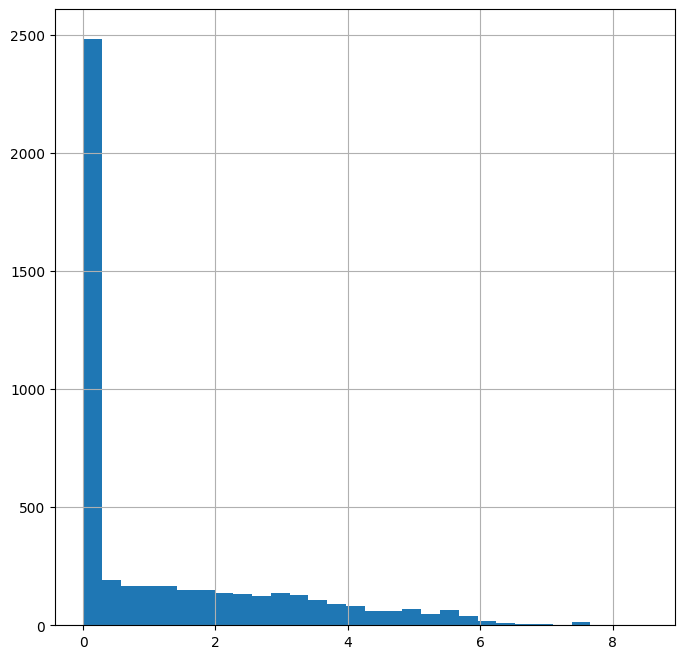

In [30]:
y_train.hist(bins=30, figsize=(8,8))
plt.show()

From our histogram of the band gaps of the train set, we can see that the majority of the data is as a conductor i.e. band gap = 0.

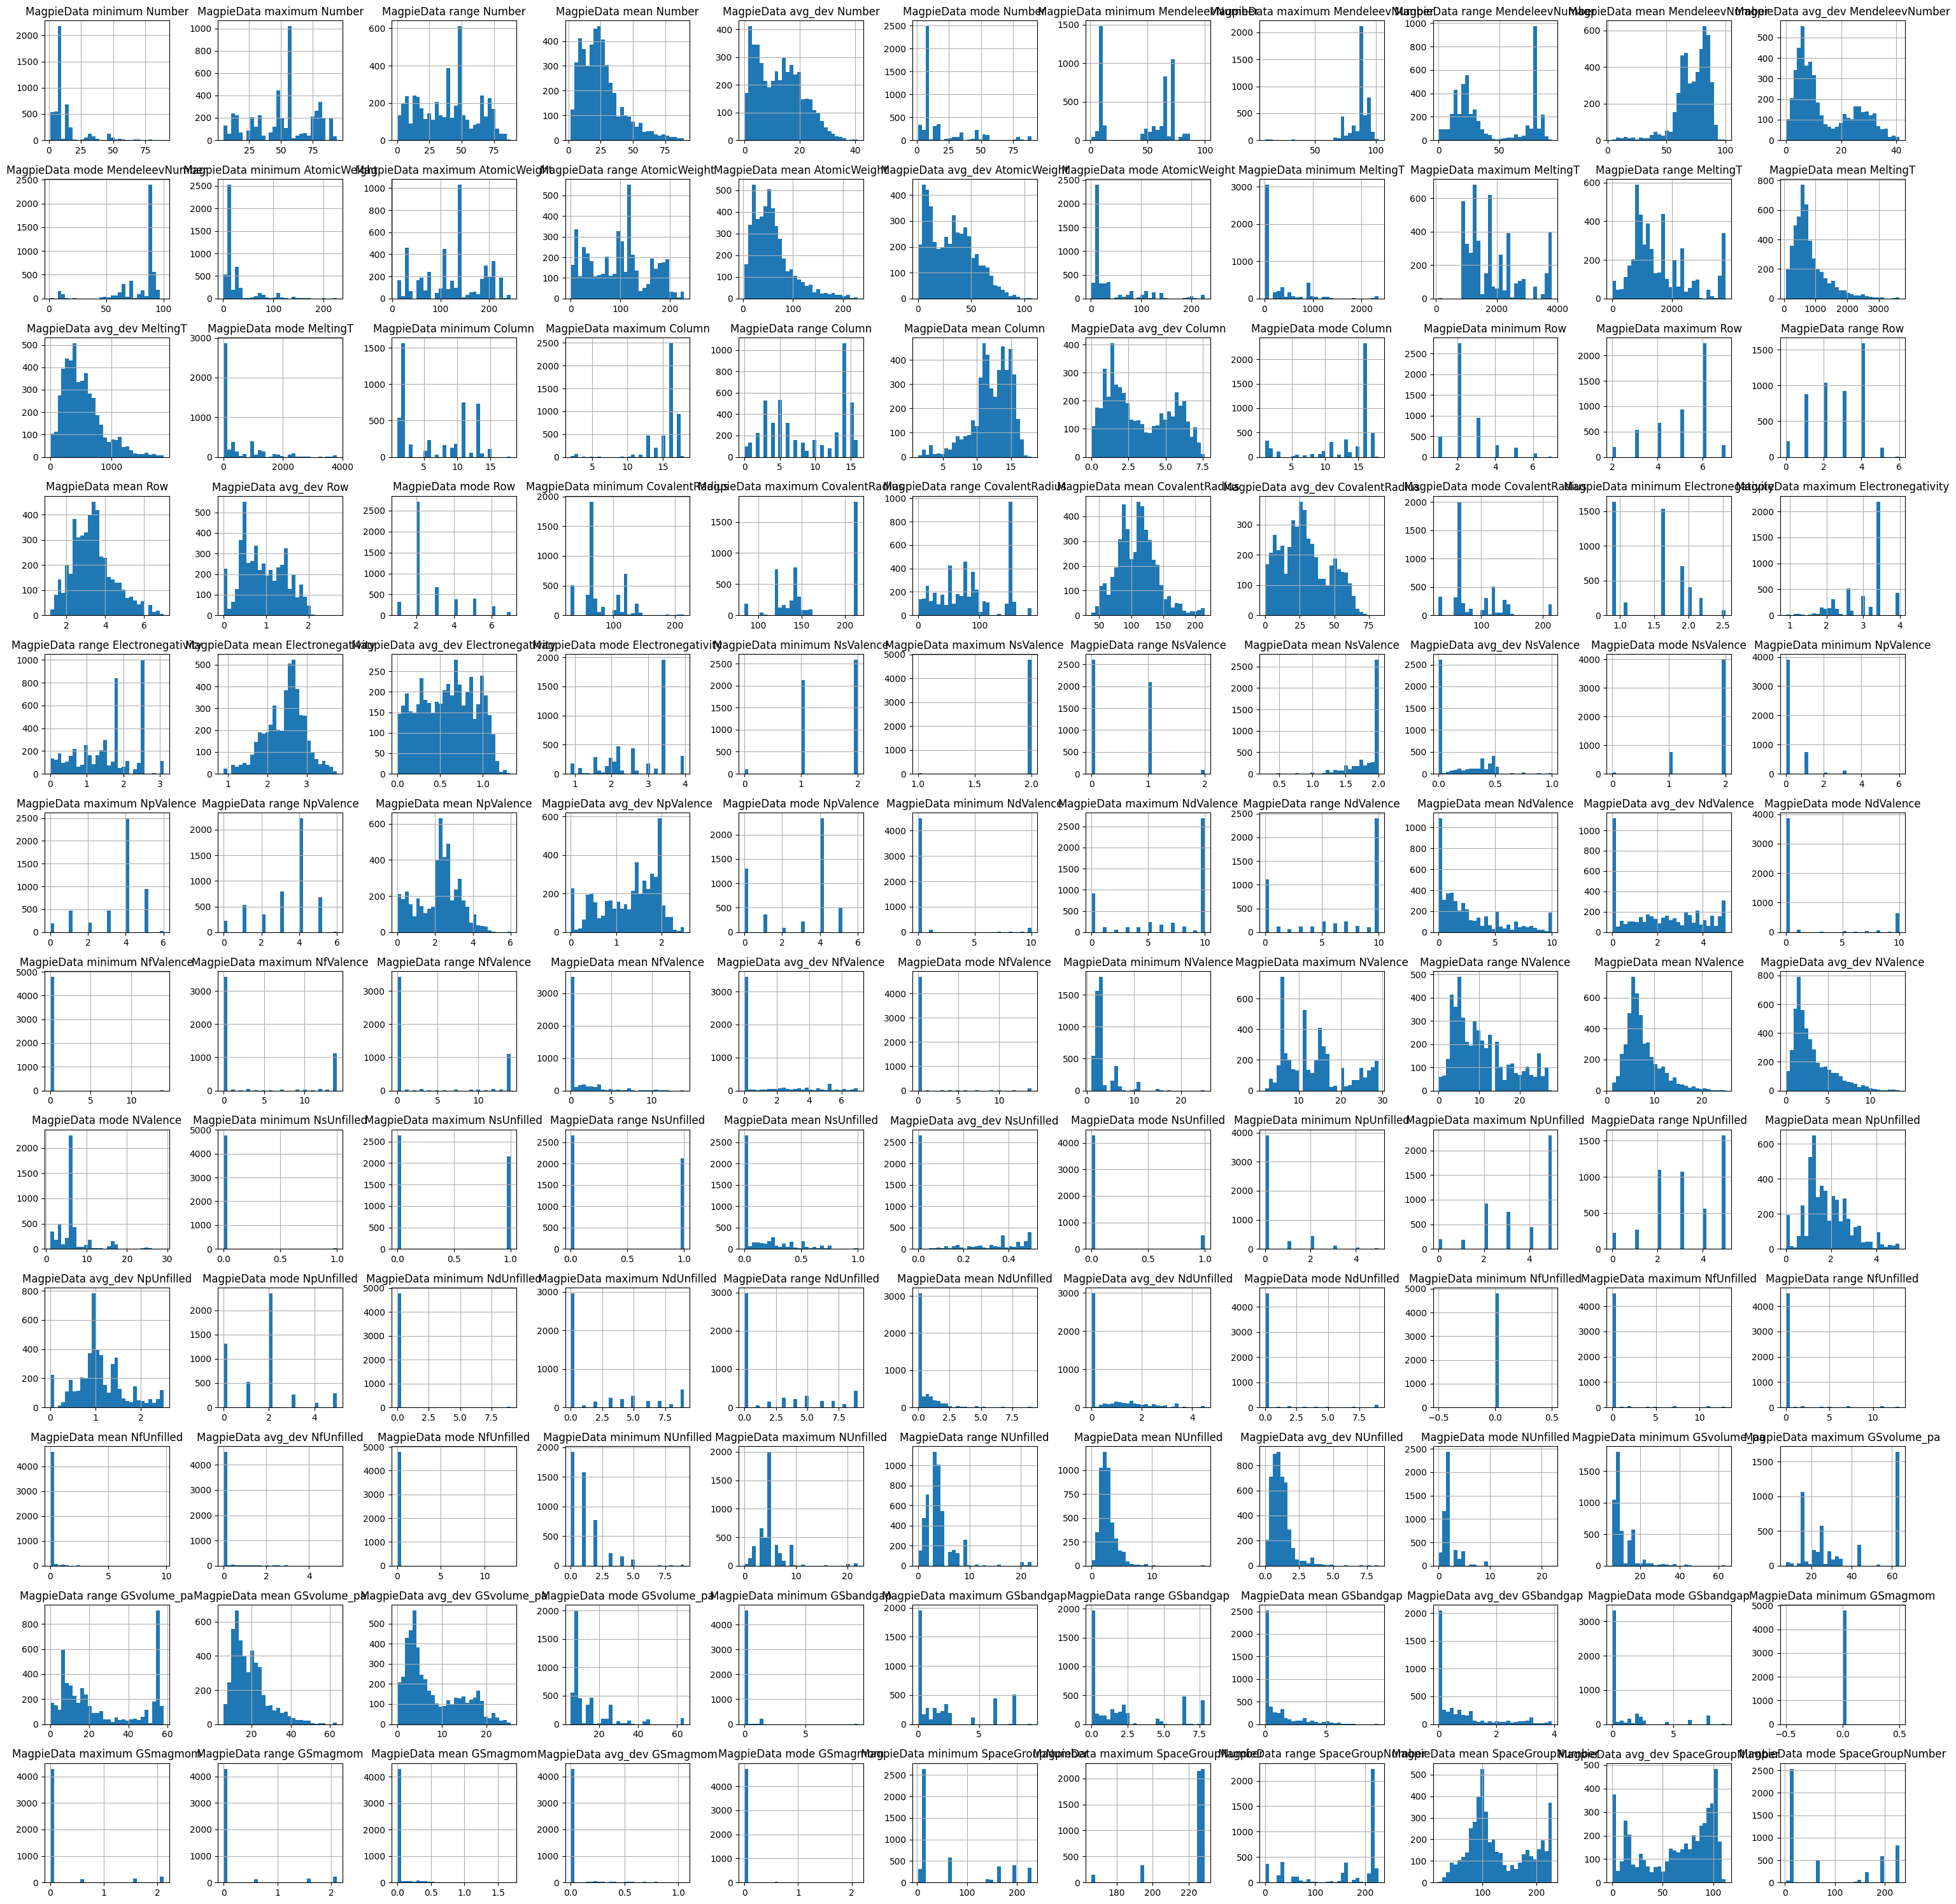

In [127]:
X_train.hist(bins=30, figsize=(30,30))
plt.tight_layout()
plt.show()

### Principal Component Analysis

In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop non-numeric columns
X_num = X_train.drop(columns=["material_id", "composition"])

#scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

Features have to be scaled before Principle Component Analysis (PCA) because without scaling the contribution of the features is over or underestimated depending on the magnitude and range of the respective features.

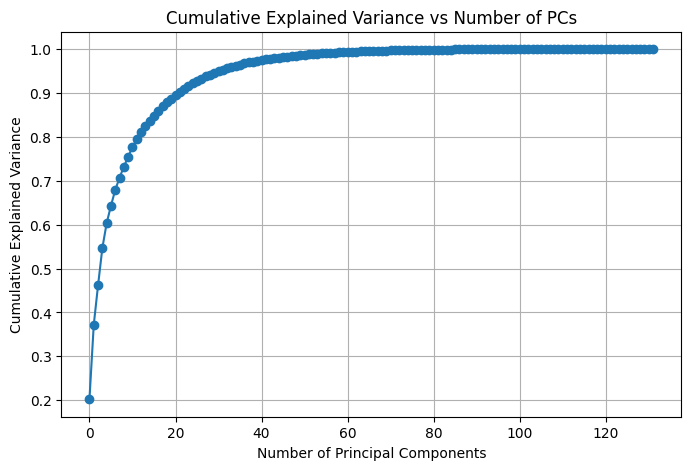

In [132]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# X_scaled = your standardized feature matrix
pca = PCA().fit(X_scaled)

# Cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance vs Number of PCs")
plt.grid(True)
plt.show()

In [133]:
n_components = np.argmax(cum_var >= 0.95) + 1
print("Number of PCs for 95% variance:", n_components)

Number of PCs for 95% variance: 31


We want our PCA to capture 95% of our data's variance. As such we are going to use 31 principle components.

In [134]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

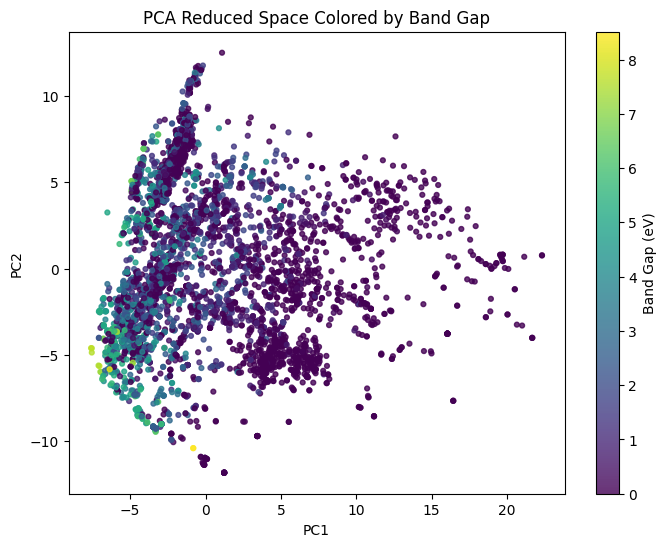

In [135]:
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                 c=y_train, cmap='viridis', s=12, alpha=0.8)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Reduced Space Colored by Band Gap")

cbar = plt.colorbar(sc)
cbar.set_label("Band Gap (eV)")

plt.show()

In [136]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index= X_num.columns)

loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31
MagpieData minimum Number,0.154984,0.006567,0.040346,-0.042880,-0.132360,0.058622,0.019630,0.073091,-0.036954,-0.019153,...,0.005880,0.131176,0.107370,-0.047291,-0.047406,0.105049,0.010767,0.063820,0.030422,-0.110014
MagpieData maximum Number,0.087842,0.152824,0.092202,0.006289,0.105455,0.042347,-0.025085,-0.006472,-0.042827,0.054671,...,-0.007950,0.065796,-0.020199,0.078351,0.049426,-0.067190,0.042726,0.042162,-0.006965,-0.044955
MagpieData range Number,0.005940,0.157413,0.074629,0.030602,0.185157,0.011861,-0.037416,-0.047687,-0.024481,0.068334,...,-0.011668,-0.003987,-0.081321,0.109026,0.078602,-0.129555,0.039015,0.008760,-0.024350,0.014124
MagpieData mean Number,0.170686,0.067815,0.075457,-0.008922,-0.034486,0.030899,-0.012502,0.031801,0.001027,-0.004887,...,0.037518,0.009932,0.020561,-0.060987,-0.041729,0.012939,0.012165,-0.005218,0.024906,-0.043529
MagpieData avg_dev Number,0.033425,0.146163,0.063674,0.025141,0.182535,0.016722,-0.029413,-0.072850,-0.025930,0.041700,...,0.133210,-0.115953,-0.010047,-0.067788,-0.014671,-0.028215,-0.017362,-0.044796,0.008311,-0.043717


### Clustering

In [65]:
from sklearn.cluster import KMeans

k = 3   # choose number of clusters
kmeans = KMeans(n_clusters=k, random_state=random_seed)
klabels = kmeans.fit_predict(X_pca)

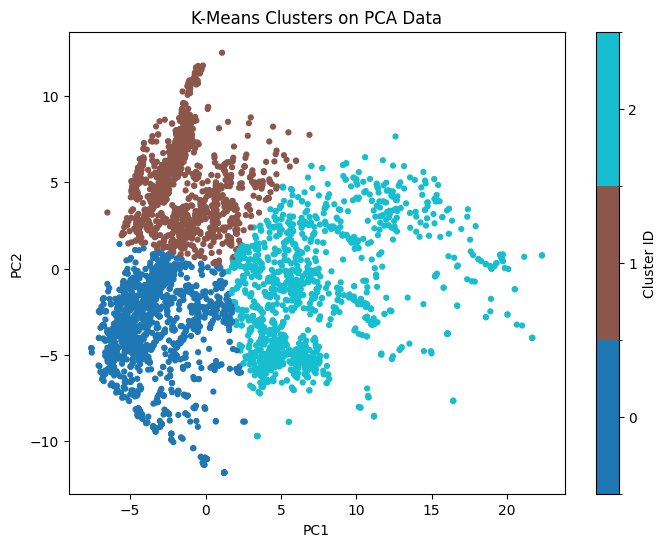

In [140]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

unique_clusters = np.unique(klabels)
cmap = plt.cm.get_cmap('tab10', len(unique_clusters))

#create boundaries for each cluster
bounds = np.arange(len(unique_clusters) + 1) - 0.5
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=klabels, cmap=cmap, norm=norm, s=12)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters on PCA Data")

cbar = plt.colorbar(sc, ticks = unique_clusters)
cbar.set_label("Cluster ID")

plt.show()


We see that from K-means clustering we get a physical distance based separation of our data. Let's see if Gaussian Mixture Models (GMM) provide a better separation.

In [141]:
from sklearn.mixture import GaussianMixture

# Choose number of clusters, here we are choosing 3 to represent conductors, semi-conductors and insulators
n_components = 3

gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_seed)
gmm_labels = gmm.fit_predict(X_pca)


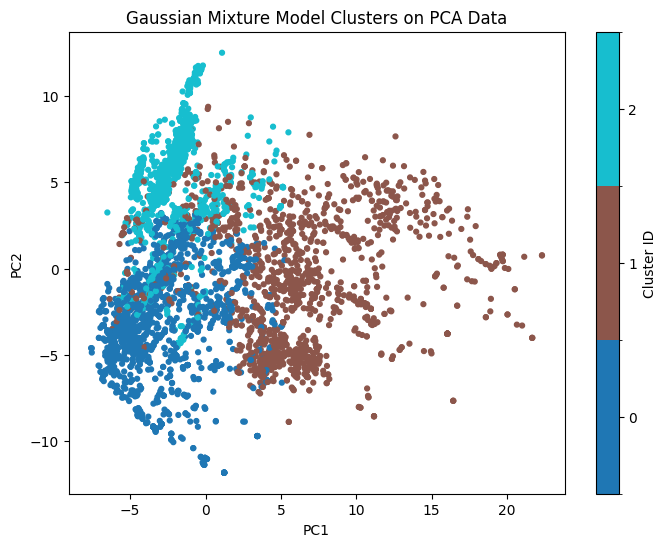

In [142]:
import matplotlib.pyplot as plt

unique_gmm = np.unique(gmm_labels)
cmap = plt.cm.get_cmap('tab10', len(unique_gmm))

#create boundaries for each cluster
bounds = np.arange(len(unique_gmm) + 1) - 0.5
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=gmm_labels, cmap=cmap, norm=norm, s=12)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Gaussian Mixture Model Clusters on PCA Data")

cbar = plt.colorbar(sc, ticks = unique_gmm)
cbar.set_label("Cluster ID")

plt.show()

From GMM, we can see the clusters have greater similarity to the figure coloured by band gap. This is more likely to represent the commonality between the samples in each cluster.



### Correlation and Heatmap Visualization

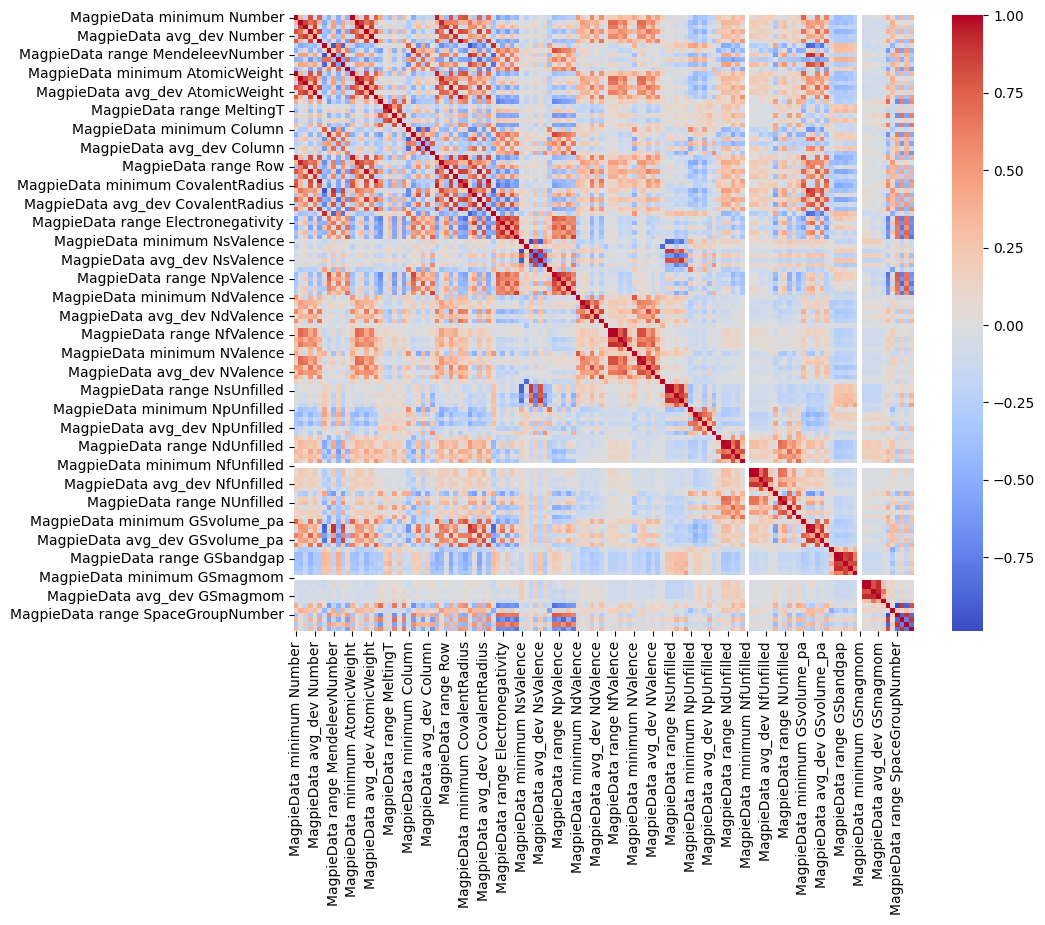

In [58]:
X_corr = X_num.corr()

#visualize correlation with heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(X_corr, annot=False, cmap='coolwarm')
plt.show()

To reduce the number of features we parse through our Random Forest (RF) model, we will be removing highly correlated features.  

In [59]:
# convert the coefficient matrix to only upper triangle
upper_tri = X_corr.where(np.triu(np.ones(X_corr.shape),k=1).astype(bool))

# find the features with absolute coefficient higher than 0.8 and store these columns names as list
to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.8)]

In [60]:
print("Dropping these features:", to_drop)

# Drop those features
X_red = X_num.drop(columns=to_drop)

#Keeping these features
print("Keeping these features:", X_red.columns)

#make new correlation matrix
X_red_corr = X_red.corr()

print("Original shape:", X_corr.shape)
print("Reduced shape:", X_red_corr.shape)

Dropping these features: ['MagpieData range Number', 'MagpieData mean Number', 'MagpieData avg_dev Number', 'MagpieData mode Number', 'MagpieData range MendeleevNumber', 'MagpieData avg_dev MendeleevNumber', 'MagpieData minimum AtomicWeight', 'MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight', 'MagpieData mean AtomicWeight', 'MagpieData avg_dev AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData range MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'MagpieData maximum Column', 'MagpieData range Column', 'MagpieData avg_dev Column', 'MagpieData minimum Row', 'MagpieData maximum Row', 'MagpieData range Row', 'MagpieData mean Row', 'MagpieData avg_dev Row', 'MagpieData mode Row', 'MagpieData minimum CovalentRadius', 'MagpieData maximum CovalentRadius', 'MagpieData range CovalentRadius', 'MagpieData mean CovalentRadius', 'MagpieData avg_dev CovalentRadius', 'MagpieData mode CovalentRadius', 'MagpieData minimum Electronegativity', 'MagpieData max

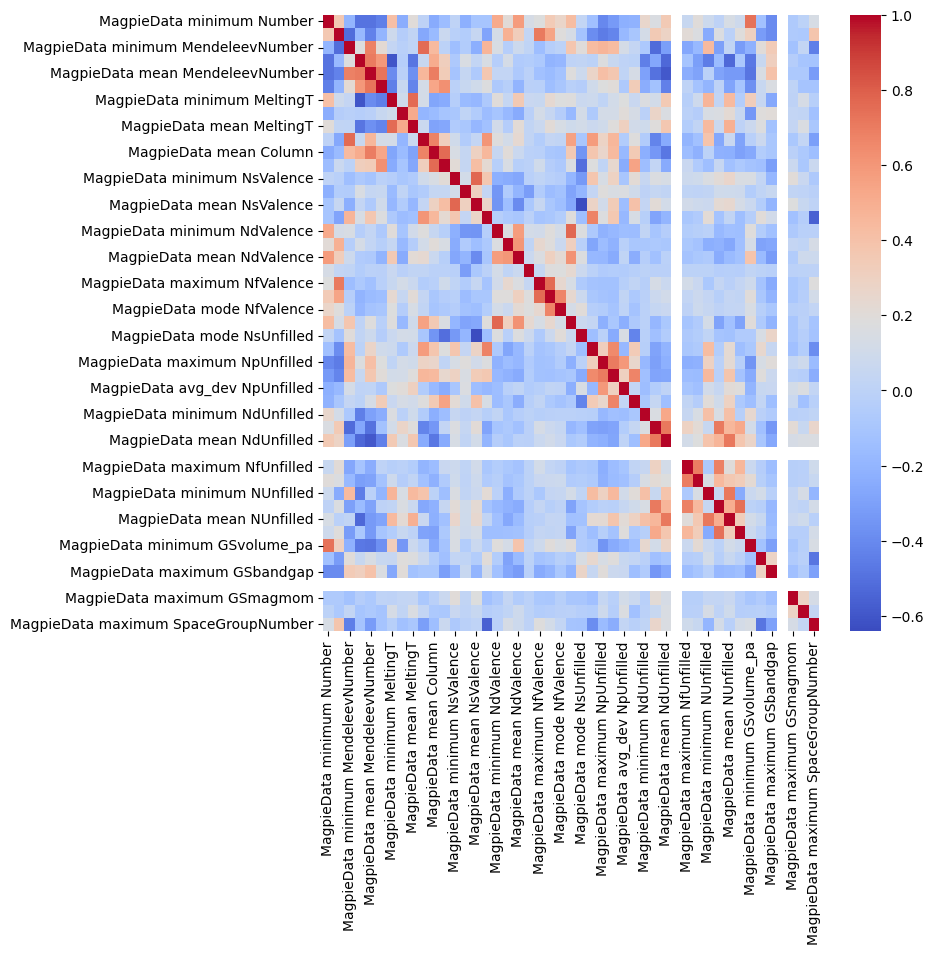

In [61]:
plt.figure(figsize=(8, 8))
sns.heatmap(X_red_corr, annot=False, cmap='coolwarm')
plt.show()

The predominant blue in the heatmap with the dropped features show that highly correlated features have been removed.

## Cross Validation

In [143]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error,mean_squared_error, max_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GroupKFold

In [144]:
LOCO = GroupKFold(n_splits=3) #leave one cluster out (LOCO) using Group K fold

LOCO_cv = list(gkf.split(X_red, y_train, groups=gmm_labels))

In [145]:
results = pd.DataFrame(columns=['mae_train', 'mse_train', 'maxe_train', 'mape_train', 'r2_train', 'mae_cv', 'mse_cv', 'maxe_cv', 'mape_cv', 'r2_cv'])

def compute_metrics(y_true, y_pred, model, train_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    maxe = max_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics_dict = {
    f"mae_{train_type}":  [mae],
    f"mse_{train_type}":  [mse],
    f"maxe_{train_type}": [maxe],
    f"mape_{train_type}": [mape],
    f"r2_{train_type}":   [r2]}

    for col, val in metrics_dict.items():
            results.loc[model, col] = val

    return results.loc[model]

In [146]:
kfold = KFold(n_splits=3, shuffle=True, random_state=random_seed)

k_cv = list(kfold.split(X_red, y_train))

## Random Forest Model

Lets start by defining the initial pipeline for our Random Forest (RF) model.

In [147]:
from sklearn.ensemble import RandomForestRegressor

#defining the random forest regressor model
rf = Pipeline([
    ('scaler', StandardScaler()),
    ("model", RandomForestRegressor(random_state=random_seed))])

We're then going to set up a grid for hyperparameter tuning of our RF model.

In [148]:
param_grid_rf = {
    'model__n_estimators': [50, 100, 200, 300, 500],
    'model__max_features': ['log2', 'sqrt', 0.5, 0.7, 0.9],
    'model__max_depth': [10, 20, 30, None]}

random_search_rf_LOCO = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_grid_rf,
    n_iter=10,
    cv=LOCO_cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=random_seed)

random_search_rf_LOCO.fit(X_red, y_train)

best_params_LOCO = random_search_rf.best_params_
best_mse_LOCO = -random_search_rf.best_score_

print(f"Best parameters for Random Forest: {best_params_LOCO}")
print(f"Best cross-validated MSE with best parameters: {best_mse_LOCO}")

LOCO_params = {key.replace('model__', ''): value for key, value in best_params_rf.items()} #this is done to solve a compatibility issue

Best parameters for Random Forest: {'model__n_estimators': 300, 'model__max_features': 'log2', 'model__max_depth': 30}
Best cross-validated MSE with best parameters: 2.1403891640182873


Now we are going to modify our pipeline so that we are using the optimal parameters. And see how this changes the performance of the model over the entire training data and the cross validated data.

In [149]:
RF_LOCO = Pipeline([
    ('scaler', StandardScaler()),
    ("model", RandomForestRegressor(**LOCO_params, random_state=random_seed))])

RF_LOCO.fit(X_red, y_train)

y_pred_train_RF_LOCO = RF_LOCO.predict(X_red)

In [150]:
#cross-validation with the optimized model
y_pred_cv_RF_LOCO = cross_val_predict(RF_LOCO, X_red, y_train, cv=LOCO_cv)

#add row to results with RF_opt
results.loc['RF_LOCO'] = [0] * 10
results.loc['RF_LOCO'] = compute_metrics(y_train, y_pred_train_RF_LOCO, "RF_LOCO", "train")
results.loc['RF_LOCO'] = compute_metrics(y_train, y_pred_cv_RF_LOCO, "RF_LOCO", "cv")

In [151]:
results

,mae_train,mse_train,maxe_train,mape_train,r2_train,mae_cv,mse_cv,maxe_cv,mape_cv,r2_cv
RF_LOCO,0.283359,0.26373,4.618912,332945636111160,0.910681,1.083975,1.88487,5.839181,1.753369e+15,0.361639


Here we can see with the LOCO cross validation strategy our models performance drops as MAE goes from 0.28 to 1.23 eV. R² drops from 0.91 to 0.28.

This is expected with LOCO cross validation. LOCO tests whether the model can generalize to new chemical families it has never seen. The clusters are suggested to group the data into 3 clusters that ideally would represent conductors, semi-conductors and insulators. In this scenario, is having a hard time learning from one type of material and applying the same principles to the other two.

Let's see if regular k fold cross validation helps.

In [152]:
random_search_rf_k = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_grid_rf,
    n_iter=10,
    cv=k_cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=random_seed)

random_search_rf_k.fit(X_red, y_train)

best_params_rf_k = random_search_rf_k.best_params_
best_mse_rf_k = -random_search_rf_k.best_score_

print(f"Best parameters for Random Forest: {best_params_rf_k}")
print(f"Best cross-validated MSE with best parameters: {best_mse_rf_k}")

rf_params_k = {key.replace('model__', ''): value for key, value in best_params_rf_k.items()} #this is done to solve a compatibility issue

Best parameters for Random Forest: {'model__n_estimators': 500, 'model__max_features': 'sqrt', 'model__max_depth': 30}
Best cross-validated MSE with best parameters: 0.9896087463279822


In [153]:
RF_k = Pipeline([
    ('scaler', StandardScaler()),
    ("model", RandomForestRegressor(**rf_params_k, random_state=random_seed))])

RF_k.fit(X_red, y_train)

y_pred_train_RF_k = RF_k.predict(X_red)

In [154]:
#cross-validation with the optimized model
y_pred_cv_RF_k = cross_val_predict(RF_k, X_red, y_train, cv=k_cv)

#add row to results with RF_opt
results.loc['RF_k'] = [0] * 10
results.loc['RF_k'] = compute_metrics(y_train, y_pred_train_RF_k, "RF_k", "train")
results.loc['RF_k'] = compute_metrics(y_train, y_pred_cv_RF_k, "RF_k", "cv")

In [155]:
results

,mae_train,mse_train,maxe_train,mape_train,r2_train,mae_cv,mse_cv,maxe_cv,mape_cv,r2_cv
RF_LOCO,0.283359,0.263730,4.618912,3.329456e+14,0.910681,1.083975,1.884870,5.839181,1.753369e+15,0.361639
RF_k,0.282900,0.262519,4.615700,3.341320e+14,0.911091,0.626321,0.989609,5.278220,7.995055e+14,0.664843


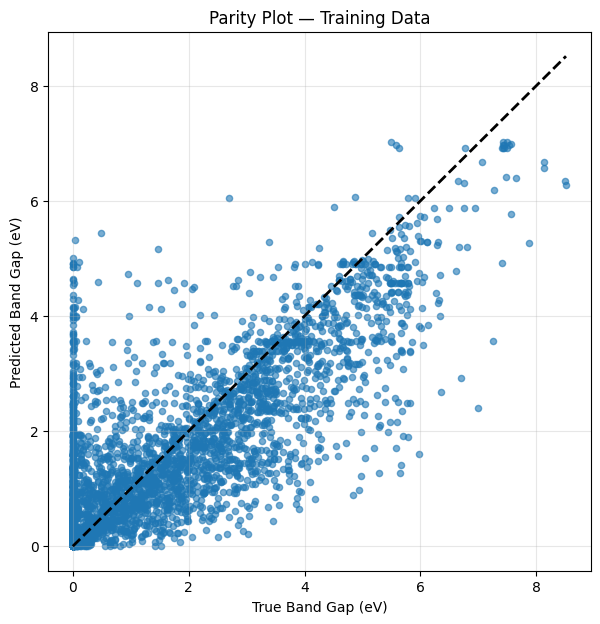

In [156]:
plt.figure(figsize=(7, 7))

# Scatter plot of true vs predicted
plt.scatter(y_train, y_pred_cv_RF_k, s=20, alpha=0.6)

# Parity line (y = x)
min_val = min(y_train.min(), y_pred_cv_RF_k.min())
max_val = max(y_train.max(), y_pred_cv_RF_k.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Parity Plot — Training Data")

plt.grid(True, alpha=0.3)
plt.show()


We can see improved performance in K fold CV as it allows for a more even distribution of data types and points across folds to have a more generic learning approach in each one. There is however still room for development especially with a significant number of true 0 band gaps that were predicted with much higher values.

<Figure size 1800x500 with 0 Axes>

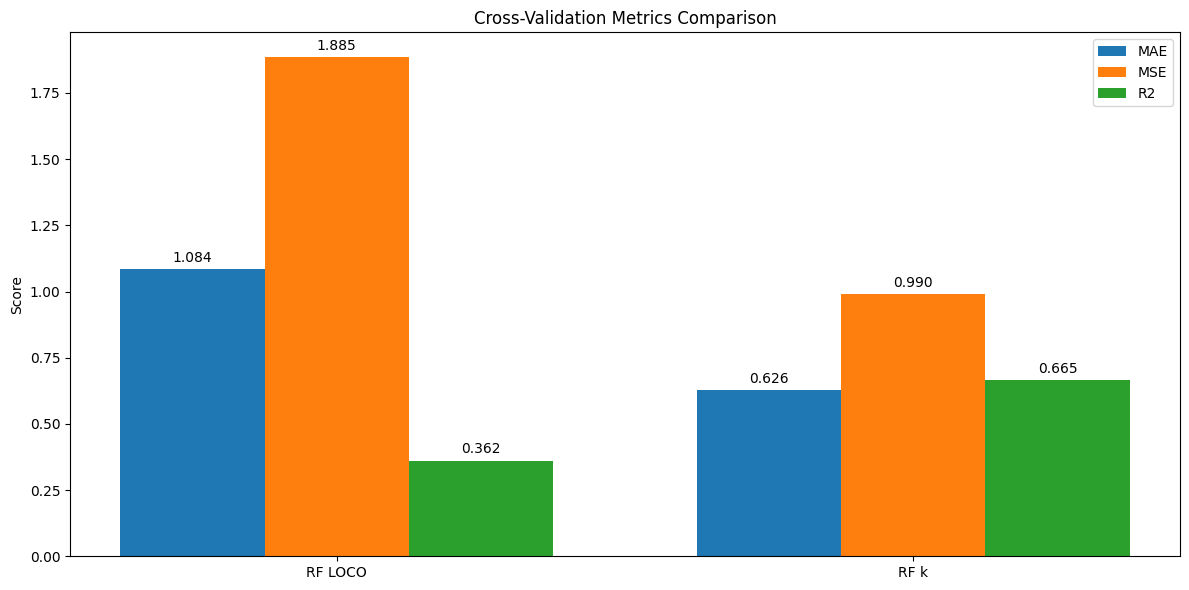

In [157]:
# Prepare data for plotting (using cross-validated predictions)
models_data = {
    'RF LOCO': {
        'actual': y_train,
        'predicted': y_pred_cv_RF_LOCO,
        'mae': results.loc['RF_LOCO', 'mae_cv'],
        'mse': results.loc['RF_LOCO', 'mse_cv'],
        'r2': results.loc['RF_LOCO', 'r2_cv']
    },
    'RF k': {
        'actual': y_train,
        'predicted': y_pred_cv_RF_k,
        'mae': results.loc['RF_k', 'mae_cv'],
        'mse': results.loc['RF_k', 'mse_cv'],
        'r2': results.loc['RF_k', 'r2_cv']
    },
}

plt.figure(figsize=(18, 5))


# Plot 2: Comparison of Cross-Validation Metrics
metrics = ['MAE', 'MSE', 'R2']
model_names = list(models_data.keys())
mae_values = [data['mae'] for data in models_data.values()]
mse_values = [data['mse'] for data in models_data.values()]
r2_values = [data['r2'] for data in models_data.values()]

x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, mae_values, width, label='MAE')
rects2 = ax.bar(x, mse_values, width, label='MSE')
rects3 = ax.bar(x + width, r2_values, width, label='R2')

ax.set_ylabel('Score')
ax.set_title('Cross-Validation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Attach a text label above each bar in *rects*,
# displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

## Minimum number of samples for training.

In [175]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X_red_scaled = scaler.fit_transform(X_red)

# 1. Compute cluster centroids in PCA space
centroids = []
for c in np.unique(gmm_labels):
    centroids.append(X_pca[gmm_labels == c].mean(axis=0))
centroids = np.vstack(centroids)

# 2. Distance of each sample to its cluster centroid
distances = np.zeros(len(X_pca))
for i, c in enumerate(gmm_labels):
    distances[i] = np.linalg.norm(X_pca[i] - centroids[c])

# 3. Train a quick RF model to estimate difficulty
rf_temp = RandomForestRegressor(n_estimators=200, random_state=random_seed)
rf_temp.fit(X_red_scaled, y_train)
y_pred_temp = rf_temp.predict(X_red_scaled)

# Absolute error per sample
errors = np.abs(y_train - y_pred_temp)

# 4. Informativeness score = diversity × difficulty
informativeness = distances * errors

# Store in a DataFrame for convenience
import pandas as pd
info_df = pd.DataFrame({
    "informativeness": informativeness,
    "distance": distances,
    "error": errors,
    "cluster": gmm_labels
}).reset_index(drop=True)

info_df_sorted = info_df.sort_values("informativeness", ascending=False)
info_df_sorted.head()


,informativeness,distance,error,cluster
3191,42.906833,9.383212,4.572723,0
1235,42.906833,9.383212,4.572723,0
4480,36.272519,12.646364,2.868217,0
3427,31.087082,7.296730,4.260413,0
3255,30.653195,14.424080,2.125140,1


In [176]:
X_red_scaled = pd.DataFrame(X_red_scaled).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
gmm_labels = pd.Series(gmm_labels).reset_index(drop=True)


In [177]:
info_df_sorted = info_df.sort_values("informativeness", ascending=False).reset_index(drop=True)


In [178]:
from sklearn.metrics import mean_absolute_error, r2_score

subset_sizes = [50, 100, 200, 400, 800, 1200, 2000, len(X_red_scaled)]
results = []

for k in subset_sizes:
    # Select top-k informative samples
    selected_idx = info_df_sorted.index[:k]

    X_sub = X_red_scaled.iloc[selected_idx]
    y_sub = y_train.iloc[selected_idx]

    # Train RF on the subset
    rf = RandomForestRegressor(n_estimators=300, random_state=random_seed)
    rf.fit(X_sub, y_sub)

    # Predict on the test set
    X_test_num = X_test[X_red.columns]
    X_test_scaled = scaler.transform(X_test_num)
    y_pred_test = rf.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    results.append([k, mae, r2])

# Convert to DataFrame for plotting
results_df = pd.DataFrame(results, columns=["subset_size", "mae_test", "r2_test"])
results_df


,subset_size,mae_test,r2_test
0,50,1.050826,0.336843
1,100,0.988348,0.420068
2,200,0.876102,0.507330
3,400,0.828822,0.506315
4,800,0.780282,0.558968
5,1200,0.748615,0.570756
6,2000,0.684401,0.637154
7,4800,0.590355,0.708250


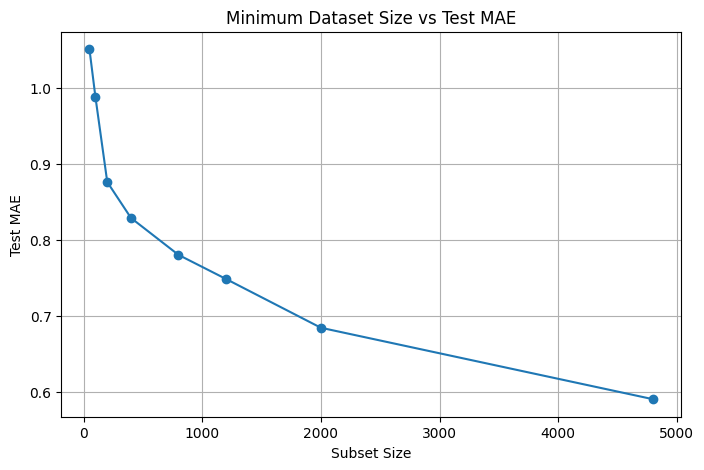

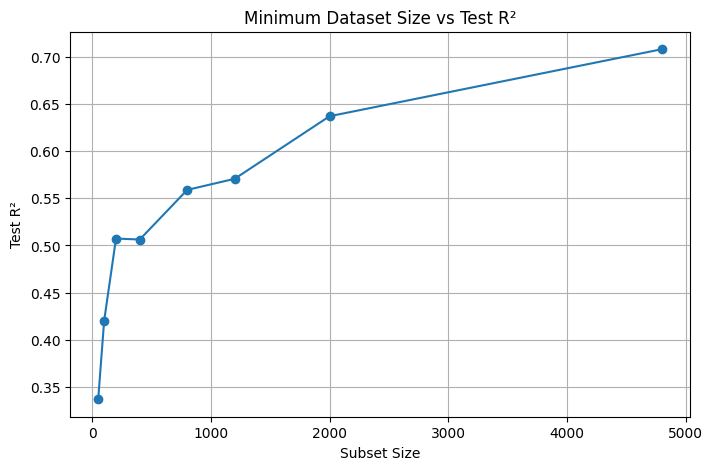

In [179]:
plt.figure(figsize=(8,5))
plt.plot(results_df["subset_size"], results_df["mae_test"], marker="o")
plt.xlabel("Subset Size")
plt.ylabel("Test MAE")
plt.title("Minimum Dataset Size vs Test MAE")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(results_df["subset_size"], results_df["r2_test"], marker="o")
plt.xlabel("Subset Size")
plt.ylabel("Test R²")
plt.title("Minimum Dataset Size vs Test R²")
plt.grid(True)
plt.show()


We want to identify the minimum number of samples required for training our model giving a similar performance. This is to represenet how a self‑driving laboratory selects the smallest number of experiments needed to learn the underlying chemistry.

To do this information‑theoretic core‑set selection strategy. First, we reduced the feature space using PCA and clustered the materials to identify chemically similar groups. For each sample, we computed an informativeness score combining:

- Diversity: distance from the sample to its cluster centroid in PCA space. Samples far from the centroid represent an sample that acts like chemistry outlier.

- Difficulty: the prediction error of a preliminary Random Forest model. Samples with high error represent chemistry that is difficult for the model to learn.

- The product of these two quantities yields a sample‑level informativeness score. Samples were ranked from most to least informative.

To determine the minimum dataset size, we constructed subsets of increasing size (50, 100, 200, … samples), always selecting the **most informative** samples first. For each subset, we trained a Random Forest model and evaluated its performance on the test set. The point at which the test MAE and R² curves plateau indicates the smallest number of samples needed to achieve stable predictive accuracy.

This method effectively calculates and "grades" each sample by how much the model can learn from it. In the plots above, we can see that we actually choose a decent size data set for our model as both the MAE and R2 begin to plateau. This means that adding more datapoints are unlikely to improve the model significantly. However since we don't have those areas plotted i.e. > 6000 datapoints, we cannot say this definitively.

# Summary

- In conclusion, we were able to use data sourced from the Materials Project database to create a random forest model to predict bandgap of a given material.
- We were able to featurize the dataset with matminer using its composition to allow for a vast array of features to work as inputs in our machine learning model.
- We then split our dataset to train and test to avoid data leakage.
- Principal component analysis was performed to capture 95% of the variance of the data with 31 components. These were coloured with the band gap to visualize the spread of the material types of conductors, insulators and semi-conductors.
- The PCA was clustered with K means and Gaussian mixture models. GMM showed better representation of the material types.
- Correlation Heatmaps were used to down select the most important features for our model by removing highly correlated features.
- LOCO cross validation performed poorly because of the model's inability to learn different chemistries independently. K fold performed better but there is still room for model improvement.
-  We evaluated sample-informativeness scores for each sample to understand what the minimum number of data points required are while still maintaining model performance. The plots show that with the train size of 4800 we begin to plateau the performance of R2 and MAE. This suggests that we have the minimum number of samples but would have to be confirmed with a larger set to be sure that it leads to a plateau in performance.

In [200]:
!pip install nbstripout


Could not strip 'MSE1003_Assignment1_RA.ipynb': file not found


In [201]:
notebook = dir + "/MSE1003_Assignment1_RA.ipynb"
!nbstripout notebook